# Estimate Neural Dimensions

### Set-up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import os

import matplotlib.pyplot as plt
import numpy as np
import skdim

import neurometry.datasets.synthetic as synthetic
from neurometry.dimension.dimension import (
    plot_dimension_experiments,
    skdim_dimension_estimation,
)

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


INFO:root:Using pytorch backend
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Show Methods Implemented in $\texttt{scikit-dimension}$

In [153]:
all_methods = [method for method in dir(skdim.id) if not method.startswith("_")]
print(all_methods)

['CorrInt', 'DANCo', 'ESS', 'FisherS', 'KNN', 'MADA', 'MLE', 'MOM', 'MiND_ML', 'TLE', 'TwoNN', 'lPCA']


### Define Parameters for Experiments

In [150]:
num_points = 2000
num_neurons = 40
max_id_dim = 20
dimensions = [_ for _ in range(1, max_id_dim + 1)]
methods = ["MLE", "lPCA", "TwoNN", "CorrInt"]
poisson_multiplier = 1
num_trials = 20
ref_frequency = 50

### Run Experiments for Hyperspheres with $\texttt{scikit-dimension}$

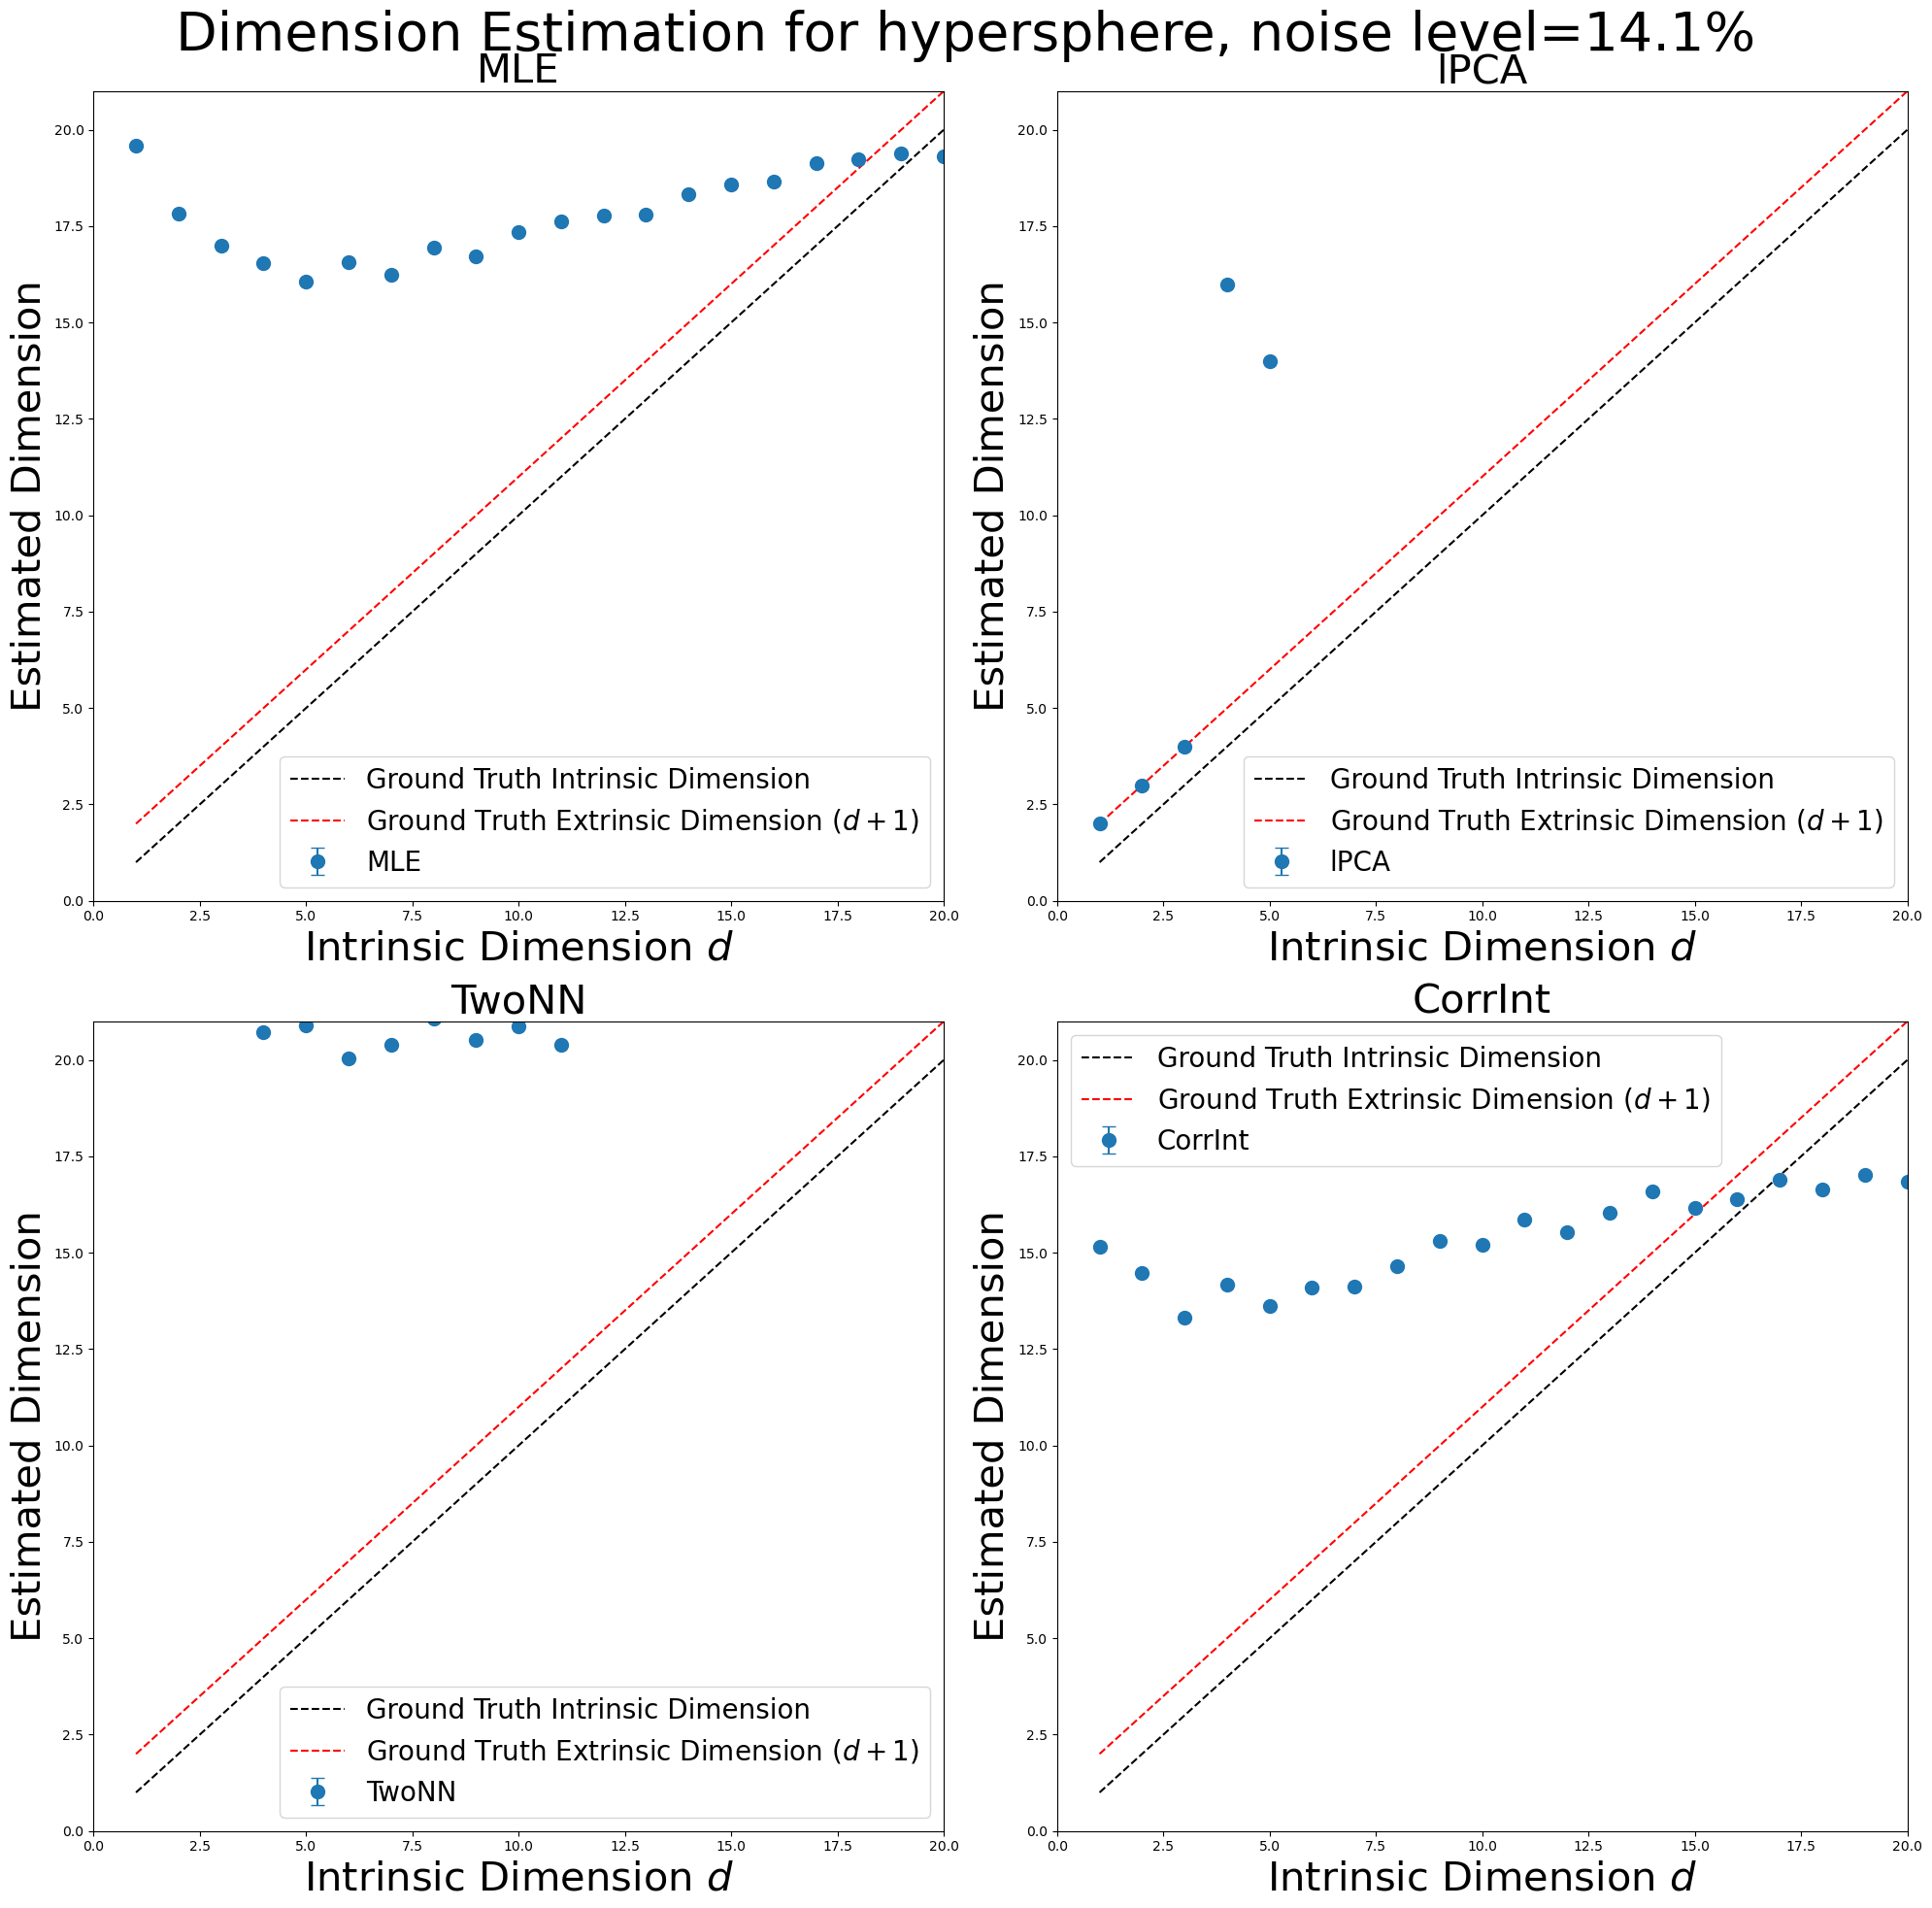

In [151]:
manifold_type = "hypersphere"
id_estimates_hyperspheres, noise_level = skdim_dimension_estimation(
    methods,
    dimensions,
    manifold_type,
    num_trials,
    num_points,
    num_neurons,
    poisson_multiplier,
    ref_frequency,
)
plot_dimension_experiments(
    id_estimates_hyperspheres, dimensions, max_id_dim, manifold_type, noise_level
)

### Run Experiments for Hypertori with $\texttt{scikit-dimension}$

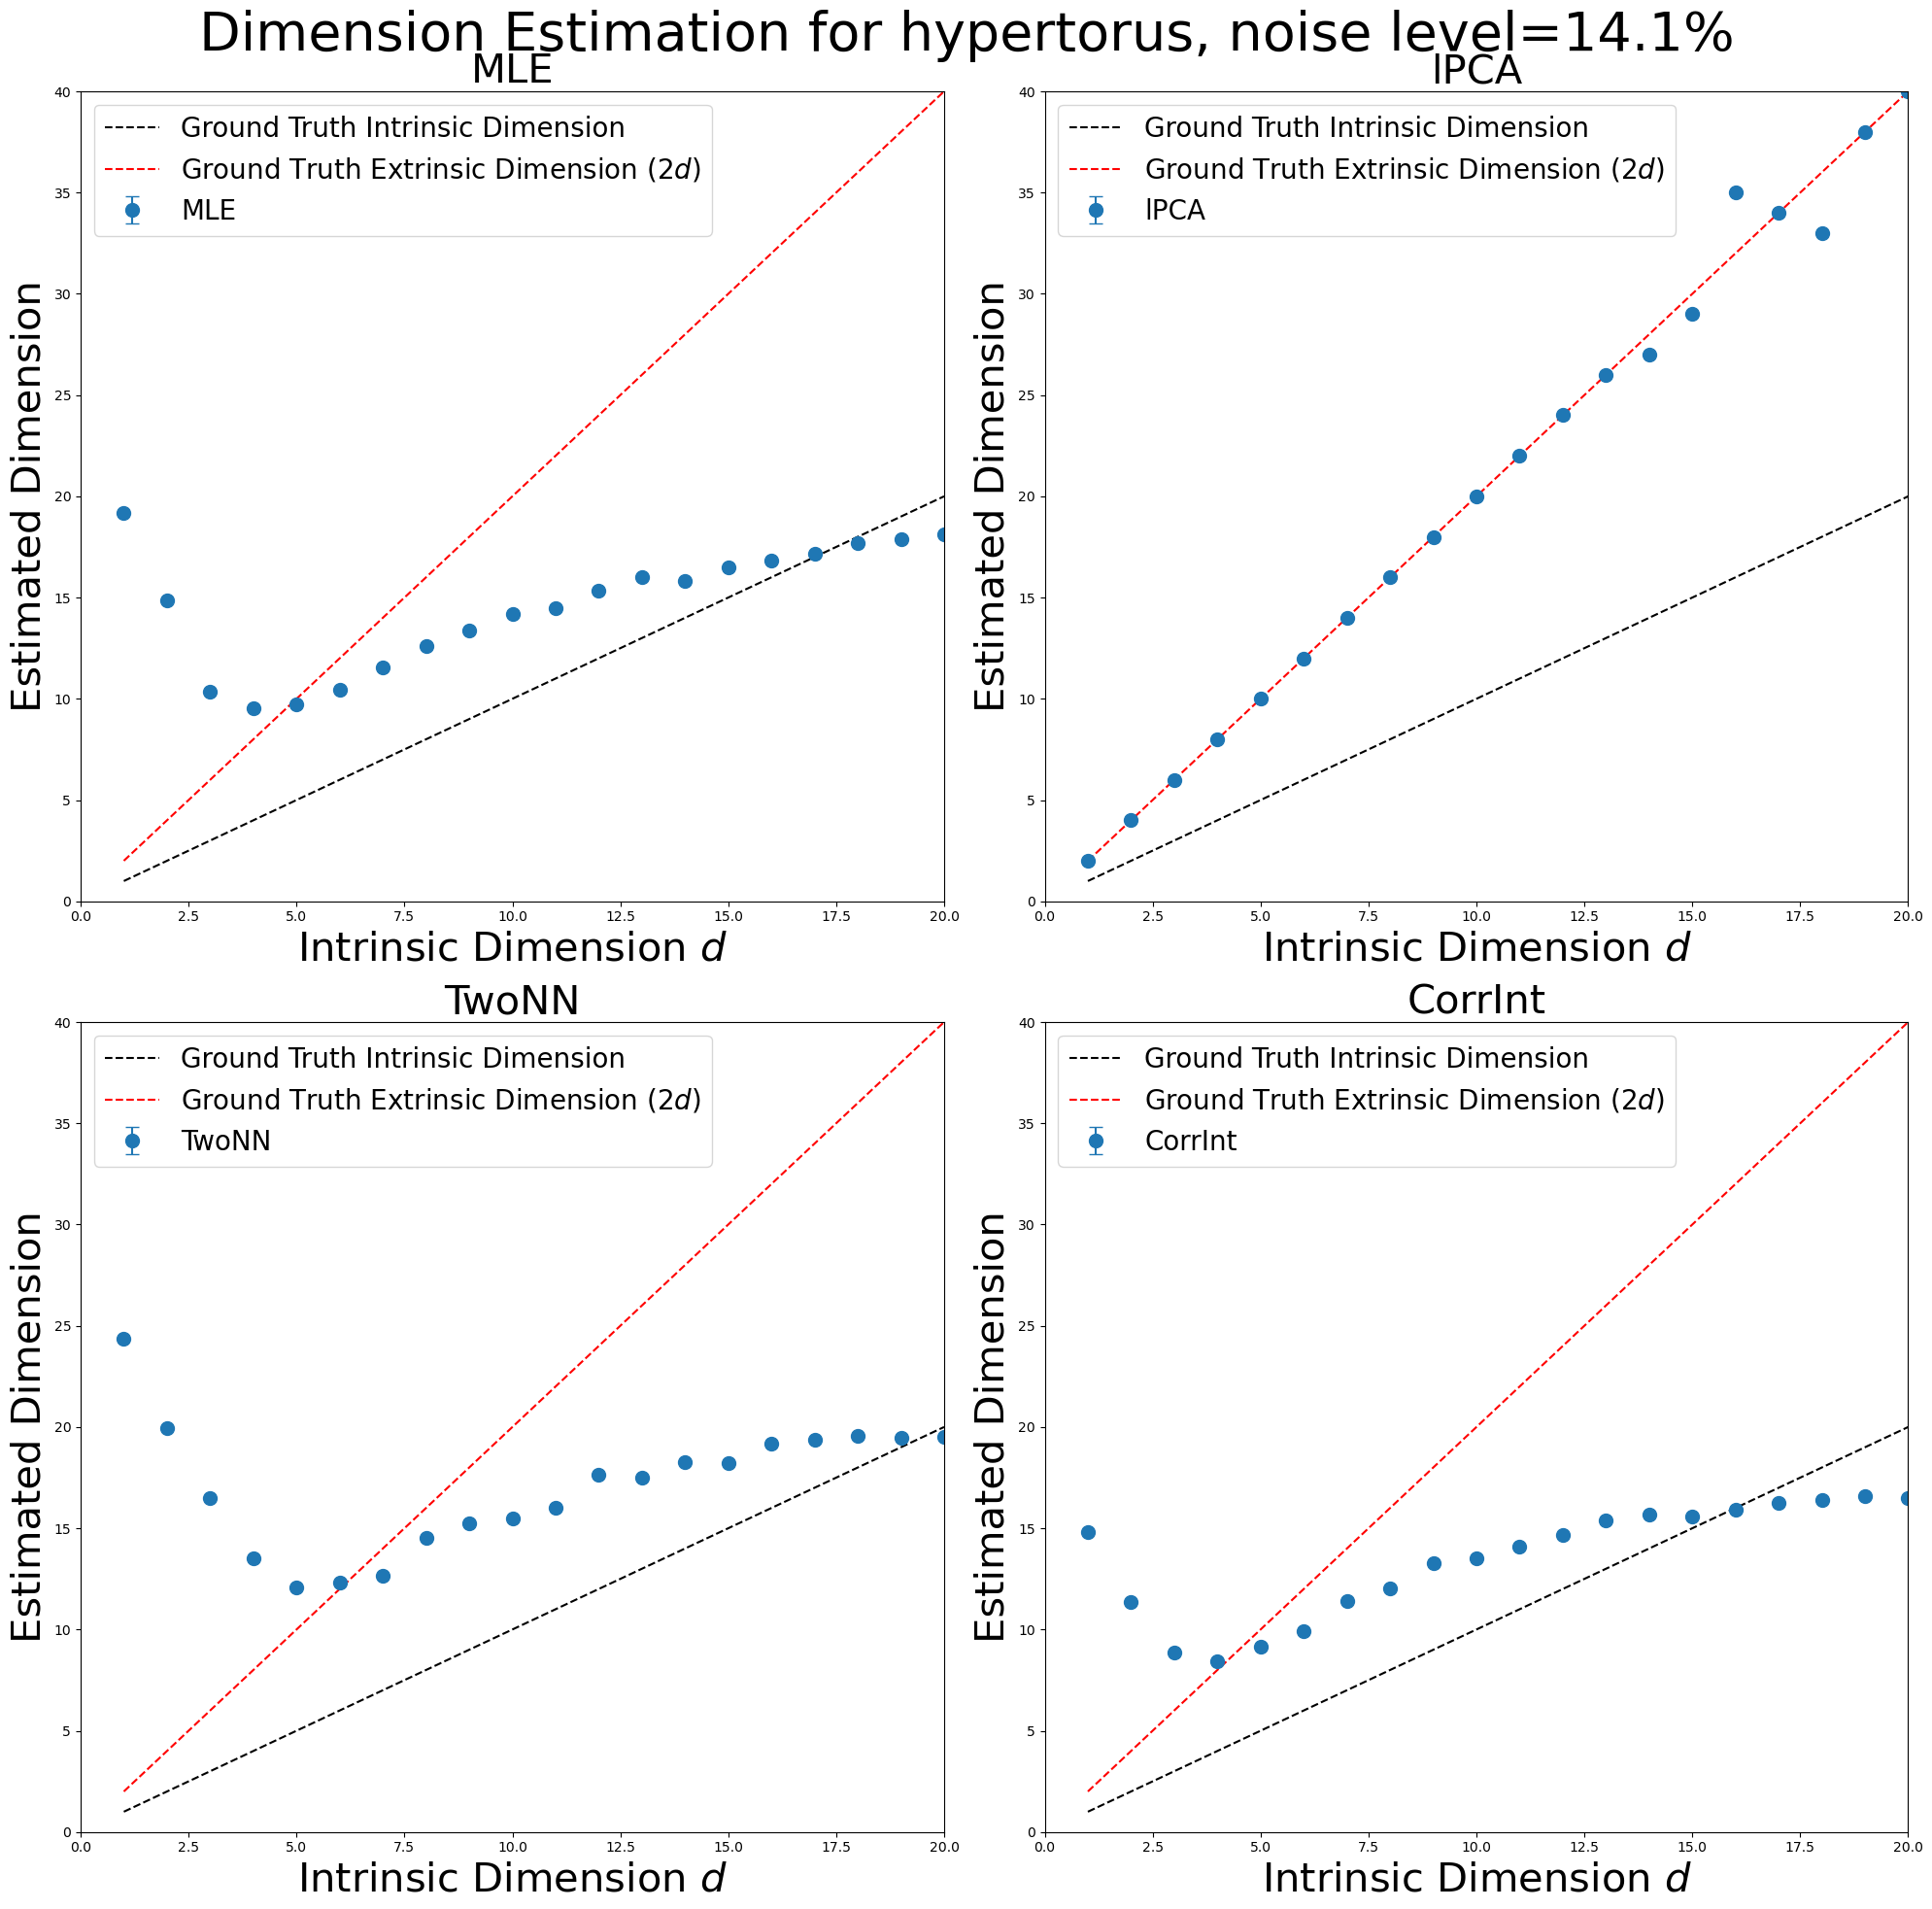

In [152]:
manifold_type = "hypertorus"
id_estimates_hypertori, noise_level = skdim_dimension_estimation(
    methods,
    dimensions,
    manifold_type,
    num_trials,
    num_points,
    num_neurons,
    poisson_multiplier,
    ref_frequency,
)
plot_dimension_experiments(
    id_estimates_hypertori, dimensions, max_id_dim, manifold_type, noise_level
)

### Try Single Experiment

In [8]:
num_points = 2000
num_neurons = 40
poisson_multiplier = 1
num_trials = 50
ref_frequency = 50
manifold_type = "hypertorus"


point_generator = getattr(synthetic, manifold_type)
points = point_generator(intrinsic_dim=1, num_points=num_points)
neural_manifold, _ = synthetic.synthetic_neural_manifold(
    points,
    num_neurons,
    "sigmoid",
    poisson_multiplier,
    ref_frequency,
    scales=gs.ones(num_neurons),
)

In [9]:
neural_manifold.shape

torch.Size([2000, 40])

In [217]:
method_name = "KNN"

method = getattr(skdim.id, method_name)()

estimates = np.zeros(num_trials)

for trial_idx in range(num_trials):
    method.fit(neural_manifold)
    estimates[trial_idx] = np.mean(method.dimension_)

print(estimates)

[ 2.  2.  3.  5.  2.  2.  4.  2.  2.  2.  2. 17.  4.  2. 40.  2.  2.  2.
  5.  3.  2.  2.  2.  3. 40.  2.  2. 11. 10.  5. 40.  2.  4.  4. 38.  3.
  3.  3.  1.  3.  2. 40.  2.  3.  2.  7.  2.  9.  2.  2.]


try: find median/mode of KNN algorithm

In [218]:
torch.median(torch.tensor(estimates))

tensor(2.)

try: first PCA data down to minimal embedding dim, then nonlinear dim est

## PLS approach

In [48]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor


def evaluate_pls_with_different_K(X, Y, K_values):
    """
    Evaluate PLS Regression followed by Multi-Output Regression for different numbers of components (K).

    Parameters:
    - X: Neural activity data (predictors)
    - Y: Continuous 2D outcomes
    - K_values: A list of integers representing different numbers of PLS components to evaluate

    Returns:
    - A list of R^2 scores corresponding to each K-value
    """
    r2_scores = []
    projected_X = []

    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    for K in K_values:
        # Initialize and fit PLS Regression
        pls = PLSRegression(n_components=K)
        pls.fit(X_train, Y_train)

        # Project both training and test data using the PLS model
        X_train_pls = pls.transform(X_train)
        X_test_pls = pls.transform(X_test)
        projected_X.append(pls.inverse_transform(X_test_pls))

        # Fit the Multi-Output Regression model on the reduced data
        multi_output_reg = MultiOutputRegressor(LinearRegression()).fit(
            X_train_pls, Y_train
        )

        # Predict and evaluate using R^2 score
        Y_pred = multi_output_reg.predict(X_test_pls)
        score = r2_score(
            Y_test, Y_pred, multioutput="uniform_average"
        )  # Average R^2 score across all outputs
        r2_scores.append(score)

    return r2_scores, projected_X

In [49]:
from sklearn.decomposition import PCA


def evaluate_PCA_with_different_K(X, Y, K_values):
    """
    Evaluate PCA for different numbers of components (K).

    Parameters:
    - X: Data to perform PCA on
    - K_values: A list of integers representing different numbers of PCA components to evaluate

    Returns:
    - A list of R^2 scores corresponding to each K-value
    """
    r2_scores = []
    projected_X = []

    # Split data into training and test sets

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    for K in K_values:
        # Initialize and fit PCA
        pca = PCA(n_components=K)
        pca.fit(X_train)

        # Project both training and test data using the PCA model
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        projected_X.append(pca.inverse_transform(X_test_pca))

        # Fit the Multi-Output Regression model on the reduced data
        multi_output_reg = MultiOutputRegressor(LinearRegression()).fit(
            X_train_pca, Y_train
        )

        # Predict and evaluate using R^2 score
        Y_pred = multi_output_reg.predict(X_test_pca)
        score = r2_score(
            Y_test, Y_pred, multioutput="uniform_average"
        )  # Average R^2 score across all outputs
        r2_scores.append(score)

    return r2_scores, projected_X

In [65]:
import numpy as np
from sklearn.model_selection import KFold


def evaluate_PCA_with_different_K_cv(X, Y, K_values, n_splits=5):
    """
    Evaluate PCA for different numbers of components (K) using cross-validation.

    Parameters:
    - X: Data to perform PCA on
    - Y: Continuous 2D outcomes
    - K_values: A list of integers representing different numbers of PCA components to evaluate
    - n_splits: Number of folds in K-Fold cross-validation

    Returns:
    - A dictionary of R^2 scores for each K-value, each containing a list of scores for each fold
    """
    cv_scores = {
        K: [] for K in K_values
    }  # Initialize dictionary to store scores for each K

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for K in K_values:
        # Loop through each fold defined by KFold
        for train_index, test_index in kf.split(X):
            # Split data into training and test sets for this fold
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Initialize and fit PCA
            pca = PCA(n_components=K)
            pca.fit(X_train)

            # Project both training and test data using the PCA model
            X_train_pca = pca.transform(X_train)
            X_test_pca = pca.transform(X_test)

            # Fit the Multi-Output Regression model on the reduced data
            multi_output_reg = MultiOutputRegressor(LinearRegression()).fit(
                X_train_pca, Y_train
            )

            # Predict and evaluate using R^2 score
            Y_pred = multi_output_reg.predict(X_test_pca)
            score = r2_score(Y_test, Y_pred, multioutput="uniform_average")
            cv_scores[K].append(score)

    return cv_scores

In [66]:
import numpy as np


def evaluate_pls_with_different_K_cv(X, Y, K_values, n_splits=5):
    """
    Evaluate PLS Regression followed by Multi-Output Regression for different numbers of components (K)
    using cross-validation.

    Parameters:
    - X: Neural activity data (predictors)
    - Y: Continuous 2D outcomes
    - K_values: A list of integers representing different numbers of PLS components to evaluate
    - n_splits: Number of folds in K-Fold cross-validation

    Returns:
    - A dictionary of R^2 scores for each K-value, each containing a list of scores for each fold
    """
    cv_scores = {
        K: [] for K in K_values
    }  # Initialize dictionary to store scores for each K

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for K in K_values:
        # Loop through each fold defined by KFold
        for train_index, test_index in kf.split(X):
            # Split data into training and test sets for this fold
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Initialize and fit PLS Regression
            pls = PLSRegression(n_components=K)
            pls.fit(X_train, Y_train)

            # Project both training and test data using the PLS model
            X_train_pls = pls.transform(X_train)
            X_test_pls = pls.transform(X_test)

            # Fit the Multi-Output Regression model on the reduced data
            multi_output_reg = MultiOutputRegressor(LinearRegression()).fit(
                X_train_pls, Y_train
            )

            # Predict and evaluate using R^2 score
            Y_pred = multi_output_reg.predict(X_test_pls)
            score = r2_score(
                Y_test, Y_pred, multioutput="uniform_average"
            )  # Average R^2 score across all outputs
            cv_scores[K].append(score)

    return cv_scores

In [90]:
import neurometry.datasets.synthetic as synthetic

N = 20

task_points = synthetic.hypertorus(2, 500)
noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=N,
    nonlinearity="sigmoid",
    poisson_multiplier=1,
    scales=gs.array(np.random.uniform(1, 3, N)),
)

noise level: 7.07%


In [91]:
import numpy as np
import torch


def add_noise_dimensions(data, n_dims):
    """
    Adds a column of random noise to the input data.

    Parameters:
    - data: A numpy array of shape (num_points, dim), where `num_points` is the number of data points
            and `dim` is the dimensionality of each data point.
    - noise_scale: The standard deviation of the Gaussian noise to be added. Default is 1.0.

    Returns:
    - A numpy array of shape (num_points, dim+1), where the last column is filled with random noise.
    """
    num_points, dim = data.shape
    noise = np.random.normal(
        loc=torch.mean(data), scale=1.5 * torch.std(data), size=(num_points, n_dims)
    )
    # noise = np.random.uniform(
    #     low=torch.min(data), high=torch.max(data), size=(num_points, n_dims)
    # )
    noisy_data = np.hstack((data, noise))

    return noisy_data

torch.Size([500, 20])
(500, 40)


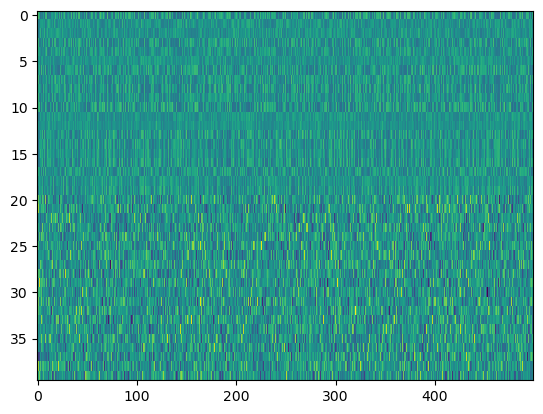

In [92]:
X = add_noise_dimensions(noisy_points, n_dims=N)
Y = task_points

print(noisy_points.shape)
print(X.shape)

plt.imshow(X.T, aspect="auto", interpolation="None");

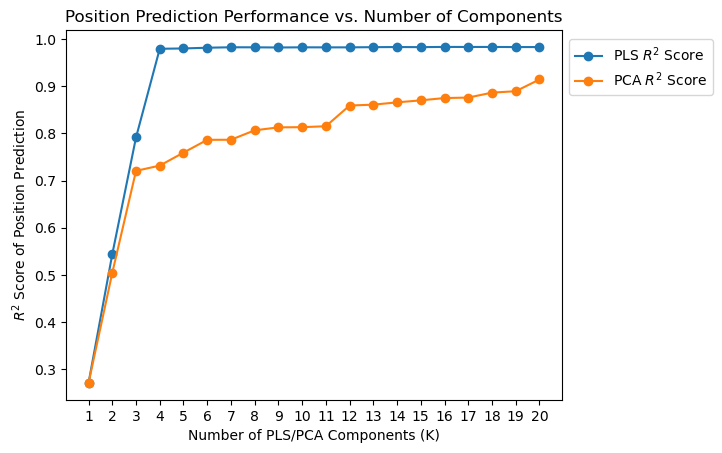

In [93]:
K_values = [i for i in range(1, N + 1)]

pls_r2_scores, pls_transformed_X = evaluate_pls_with_different_K(X, Y, K_values)

pca_r2_scores, pca_transformed_X = evaluate_PCA_with_different_K(X, Y, K_values)

plt.plot(K_values, pls_r2_scores, marker="o", label="PLS $R^2$ Score")

plt.plot(K_values, pca_r2_scores, marker="o", label="PCA $R^2$ Score")

# pls_cv_scores = evaluate_pls_with_different_K_cv(X, Y, K_values, n_splits=5)

# pca_cv_scores = evaluate_PCA_with_different_K_cv(X, Y, K_values, n_splits=5)


# plt.errorbar(
#     K_values,
#     np.mean(list(pls_cv_scores.values()), axis=1),
#     yerr=np.std(list(pls_cv_scores.values()), axis=1),
#     fmt="-o",
#     label="PLS R^2 Score",
# )

# plt.errorbar(
#     K_values,
#     np.mean(list(pca_cv_scores.values()), axis=1),
#     yerr=np.std(list(pca_cv_scores.values()), axis=1),
#     fmt="-o",
#     label="PCA R^2 Score",
# )

plt.xticks(K_values)
plt.xlabel("Number of PLS/PCA Components (K)")
plt.ylabel("$R^2$ Score of Position Prediction")
plt.title("Position Prediction Performance vs. Number of Components")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.9));

In [94]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

In [95]:
n_components = 4

X_pls = pls_transformed_X[n_components - 1]

X_pca = pca_transformed_X[n_components - 1]


vr_pers = VietorisRipsPersistence(homology_dimensions=(0, 1, 2), n_jobs=-1)

diagrams = vr_pers.fit_transform([X_pls, X_pca])

In [96]:
pls_pers_plot = plot_diagram(diagrams[0])

pls_pers_plot.update_layout(title="V-R Persist. Diag., PLS-projected data (dim=4)")

In [97]:
pca_pers_plot = plot_diagram(diagrams[1])

pca_pers_plot.update_layout(
    title=f"V-R Persist. Diag., PCA-projected data (dim={n_components})"
)

In [77]:
from gtda.diagrams import BettiCurve, Scaler


def max_function(x):
    return np.max(x)


scaler = Scaler(function=max_function)

diagrams_scaled = scaler.fit_transform(diagrams)

In [98]:
betticurves = BettiCurve(n_bins=50, n_jobs=-1)

betti_curves = betticurves.fit_transform(diagrams)

In [99]:
betticurves.plot(betti_curves, sample=0)

In [100]:
n_components = 4

X_pls = pls_transformed_X[n_components - 1]

X_pca = pca_transformed_X[n_components - 1]

from gtda.homology import WeakAlphaPersistence

wa_pers = WeakAlphaPersistence(homology_dimensions=(0, 1, 2))

diagrams_wa_pers = wa_pers.fit_transform([X_pca, X_pls])

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qt Q12 Qx Qc Qz Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1336544124  delaunay  Qtriangulate  Q12-allow-wide  Qxact-merge
  Qcoplanar-keep  Qz-infinity-point  Qbbound-last  _zero-centrum
  Qinterior-keep  Q3-no-merge-vertices-dim-high  Pgood  _max-width 2.8e+02
  Error-roundoff 1.4e-11  _one-merge 1.2e-09  Visible-distance 8.6e-11
  U-max-coplanar 8.6e-11  Width-outside 1.7e-10  _wide-facet 5.2e-10
  _maxoutside 1.2e-09

precision problems (corrected unless 'Q0' or an error)
     42 nearly singular or axis-parallel hyperplanes
      7 zero divisors during gaussian elimination

The input to qhull appears to be less than 41 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p14(v42): 1.6e+02    68 1e+02    91 1.6e+02 1e+02    40 1.5e+02 1.2e+02 1e+02 1.3e+02    71    85 1.2e+02    40    69    90    64 1.3e+02 1.1e+02 1e+02 1.1e+02    95 1.1e+02    95 1.3e+02    96    85    78    92 1e+02 1e+02 1.1e+02    73 1.2e+02    45    97    68    98    78    23
- p13(v41): 2e+02    41    64 1.1e+02 1.6e+02 1.1e+02 1.3e+02 1.2e+02 1.5e+02 1.3e+02 2e+02    48    71    51    56    44    45 1.4e+02 1.2e+02    91 1.2e+02 1.2e+02 1e+02    60    91 1.2e+02    84    90    99    74    99    69    72 1.2e+02 1.1e+02    82 1e+02    91 1.1e+02 1e+02    71
- p12(v40):  -3.9 1.4e+02 1.1e+02    22    40 1.3e+02 1.1e+02    24   1.3    32    77 1.1e+02 1.1e+02 1.7e+02 1.6e+02 1.8e+02 2e+02    47 1.4e+02 1.8e+02    98 1.2e+02    82    67    61 1.3e+02 1e+02    89    81    88    86    68 1e+02 1.1e+02 1e+02    74    85 1e+02 1.3e+02    93    76
- p11(v39): 1.9e+02    53    66 1.4e+02 1.5e+02 1e+02 1.3e+02 1.3e+02 1.6e+02 1.4e+02 1.8e+02    65    82    37    61    41    32 1.5e+02    95    64 1.2e+02 1.1e+02 1e+02    75 1e+02 1.1e+02    88 1e+02 1.1e+02    83 1e+02    86    78 1.2e+02 1e+02 1e+02    98    98 1.1e+02 1e+02    80
- p10(v38): 1.9e+02    54 1.2e+02 1.1e+02 1.8e+02    70   3.5 1.9e+02 1.7e+02 1.2e+02 1.2e+02    78    81 1e+02    19    42    50    65 1.2e+02    70    89    87 1.2e+02 1.8e+02 1.5e+02    74    93 1.1e+02 1.3e+02 1.3e+02    80 1.6e+02 1.1e+02    52 1.3e+02 1.1e+02 1.2e+02    77    79    76 1.2e+02
- p9(v37):    64    98    82    68    65 1.2e+02 1.8e+02    22    77    73 1.5e+02    89    86    72 1.6e+02 1.3e+02 1.1e+02 1.4e+02 1.1e+02 1.3e+02 1.1e+02 1.1e+02 1.1e+02    71 1e+02    66    84 1.1e+02 1.6e+02 1e+02    59    72    54 1.5e+02 1.1e+02 1.8e+02 1.1e+02 1.4e+02 1.3e+02 1.2e+02 1.1e+02
- p8(v36): 1e+02    79    97    54 1.1e+02 1.2e+02 1.2e+02    67    90    68 1.5e+02    74    77    99 1.2e+02 1.1e+02 1.1e+02    96 1.4e+02 1.4e+02 1e+02 1.2e+02 1.1e+02    95 1e+02    81    85 1e+02 1.4e+02 1.1e+02    62    86    68 1.1e+02 1.2e+02 1.4e+02 1.1e+02 1.2e+02 1.2e+02 1e+02    55
- p7(v35):    32 1.3e+02 1.2e+02    33    68 1.3e+02    73    60    18    45    81 1e+02 1e+02 1.8e+02 1.2e+02 1.6e+02 1.9e+02    32 1.4e+02 1.8e+02    99 1.2e+02    76    69    56 1.5e+02 1e+02    80    57    80 1e+02    71 1.2e+02    92 1e+02    34    80    83 1.2e+02    82    39
- p6(v34):    26 1.3e+02    86    44    46 1.4e+02 1.5e+02    16    13    54 1.2e+02    95 1e+02 1.4e+02 1.6e+02 1.6e+02 1.8e+02    86 1.3e+02 1.7e+02 1.1e+02 1.3e+02    76    20    42 1.5e+02    98    83    63    61 1e+02    36    93 1.3e+02    90    56    76 1e+02 1.4e+02 1e+02    59
- p4(v33): 1.2e+02    69    83    45 1.2e+02 1.4e+02 1.1e+02    69    74    68 1.8e+02    55    72 1.1e+02    98 1.1e+02 1.2e+02    83 1.5e+02 1.6e+02 1.1e+02 1.3e+02    96    49    67 1.3e+02    86    77    92    75    85    52    75 1.1e+02 1.2e+02    69    99    93 1.2e+02    99    32
- p3(v32): 1.4e+02    76    68 1.1e+02 1.1e+02 1.2e+02 1.5e+02    86 1.2e+02 1.2e+02 1.6e+02    75    88    59    98    77    71 1.5e+02 1e+02    94 1.2e+02 1.1e+02    97    54    87 1.2e+02    89 1e+02 1e+02    76 1e+02    68    77 1.3e+02    98    98    92 1.1e+02 1.2e+02 1.1e+02    42
- p2(v31): 2.1e+02    53    77 1.3e+02 1.8e+02 1e+02    56 1.8e+02 1.4e+02 1.4e+02 1.6e+02    57    88    95   4.3    34    60    91 1.2e+02    84 1.2e+02 1.1e+02    78    62    70 1.8e+02 1e+02    72    26    55 1.4e+02    79 1.2e+02    79    98   -22    76    44 1e+02    75    60
- p0(v30):   9.4 1.4e+02 1.3e+02    18    60 1.2e+02    62    53    14    30    63 1.1e+02 1e+02 1.9e+02 1.4e+02 1.7e+02 2e+02    20 1.4e+02 1.8e+02    89 1.1e+02    87 1e+02    75 1.2e+02 1e+02    89    87 1e+02    81    91 1.1e+02    86 1.1e+02    73    92    95 1.2e+02    83    69
- p20(v29):    19 1.5e+02    91 1.2e+02    24 1e+02 1.7e+02    40    62 1e+02    53 1.4e+02 1.3e+02    91 1.7e+02 1.4e+02 1.3e+02 1.4e+02    59    94 1.1e+02    94    86    72    91    96 1e+02 1.2e+02 1e+02    92 1e+02    89 1e+02 1.4e+02    75 1.3e+02    78 1.3e+02 1.2e+02 1.1e+02    75
- p1(v28):     3 1.5e+02 1.1e+02    30    44 1.4e+02    91    39  -6.7    40    68 1.1e+02 1.1e+02 1.9e+02 1.4e+02 1.8e+02 2.1e+02    34 1.3e+02 1.9e+02 1e+02 1.2e+02    67    48    40 1.6e+02 1.1e+02    77    40    69 1.1e+02    57 1.2e+02 1e+02    90    18    70    84 1.3e+02    84    67
- p35(v27): 1.3e+02    75 1.1e+02    48 1.4e+02 1.1e+02    31 1.2e+02    86    68 1.4e+02    69    80 1.5e+02    60    99 1.3e+02    34 1.6e+02 1.5e+02    98 1.2e+02    95 1e+02    84 1.3e+02    95    77    81    94    90    93 1.1e+02    70 1.2e+02    44 1e+02    70 1e+02    77    23
- p25(v26):    49 1e+02 1e+02    46    68 1.2e+02 1.4e+02    30    65    55 1.3e+02    94    86 1e+02 1.6e+02 1.4e+02 1.3e+02 1e+02 1.2e+02 1.4e+02 1e+02 1.1e+02 1.1e+02    94 1.1e+02    63    86 1.1e+02 1.6e+02 1.2e+02    53    86    64 1.3e+02 1.2e+02 1.7e+02 1.1e+02 1.4e+02 1.2e+02 1.1e+02    93
- p98(v25): 1.9e+02    61    61 1.7e+02 1.4e+02    93 1.5e+02 1.3e+02 1.7e+02 1.6e+02 1.6e+02    76    92    19    64    33    16 1.8e+02    70    38 1.3e+02    97 1e+02    73 1.1e+02 1.1e+02    91 1.1e+02 1e+02    81 1.1e+02    91    83 1.3e+02    93 1e+02    92 1e+02 1.1e+02 1.1e+02 1e+02
- p52(v24): 2e+02    47    45 1.6e+02 1.4e+02 1.1e+02 1.9e+02 1e+02 1.7e+02 1.6e+02 2e+02    60    79  -5.3    82    32   6.8 2e+02    79    48 1.3e+02 1.1e+02 1.1e+02    51 1.1e+02    97    82 1.1e+02 1.2e+02    76    99    70    57 1.5e+02    98 1.3e+02    99 1.2e+02 1.1e+02 1.2e+02 1.5e+02
- p84(v23): 1.8e+02 1.1e+02    62 2.3e+02 1.2e+02    77 1.2e+02 1.8e+02 1.6e+02 2.1e+02    72 1.2e+02 1.3e+02    48    33    31    29 1.7e+02    21   2.4 1.3e+02    83    59    51    75 1.8e+02 1.2e+02 1e+02   0.5    44 1.9e+02    95 1.5e+02 1.1e+02    49   -15    45    59    98    84 1.2e+02
- p43(v22): 1.7e+02 1e+02 1.1e+02 2.1e+02 1.3e+02    48    56 2e+02 1.8e+02 1.8e+02    32 1.3e+02 1.3e+02    67    30    36    26 1.3e+02    30  -4.4 1e+02    62    89 1.5e+02 1.4e+02 1e+02 1.1e+02 1.3e+02    76 1.1e+02 1.4e+02 1.6e+02 1.4e+02    73    80    71    79    75    77    77 1.3e+02
- p18(v21): 1.5e+02 1.1e+02 1e+02 2.1e+02 1.2e+02    51    85 1.8e+02 1.8e+02 1.8e+02    42 1.3e+02 1.3e+02    51    53    42    22 1.5e+02    27  -4.2 1e+02    62    97 1.5e+02 1.4e+02    83 1.1e+02 1.3e+02 1e+02 1.2e+02 1.2e+02 1.6e+02 1.3e+02    88    83 1.1e+02    86    93    82    87 1.3e+02
- p16(v20): 1.3e+02    76    46 1.2e+02    89 1.3e+02 2.2e+02    46 1.1e+02 1.2e+02 1.9e+02    70    86    29 1.3e+02    83    65 1.9e+02    92    94 1.3e+02 1.2e+02    97    16    76 1.2e+02    84 1e+02 1.1e+02    62    99    40    57 1.6e+02    90 1.2e+02    89 1.3e+02 1.3e+02 1.2e+02 1e+02
- p5(v19): 1.3e+02 1.2e+02    87 2e+02    93    70 1.1e+02 1.6e+02 1.4e+02 1.8e+02    38 1.3e+02 1.4e+02    68    67    63    54 1.5e+02    26    17 1.2e+02    75    74    95 1e+02 1.4e+02 1.2e+02 1.2e+02    47    79 1.5e+02 1.2e+02 1.4e+02 1e+02    62    47    62    81    95    86    72
- p44(v18):    85 1.3e+02    94 1.6e+02    71    82 1.3e+02 1e+02 1.2e+02 1.4e+02    56 1.3e+02 1.2e+02    72 1.1e+02    95    77 1.4e+02    48    52 1.1e+02    81    92 1.1e+02 1.1e+02    92 1.1e+02 1.3e+02 1e+02 1e+02 1.1e+02 1.2e+02 1.1e+02 1.2e+02    80 1.2e+02    83 1.1e+02 1e+02 1e+02    57
- p51(v17): 1.5e+02    60    89    74 1.4e+02 1.1e+02    96 1e+02 1.1e+02    90 1.7e+02    61    73    92    79    80    87    96 1.4e+02 1.2e+02 1.1e+02 1.2e+02 1.1e+02    87    97 1e+02    86    92 1.2e+02    95    79    84    76 1e+02 1.2e+02 1e+02 1.1e+02    97 1.1e+02    98    38
- p47(v16):    30 1.6e+02 1.1e+02 1.4e+02    41    87 1e+02    99    65 1.1e+02  -1.9 1.5e+02 1.4e+02 1.3e+02 1.2e+02 1.3e+02 1.4e+02    94    52    81 1e+02    83    69    96    85 1.3e+02 1.2e+02 1.1e+02    50    88 1.3e+02 1.1e+02 1.5e+02    98    66    52    62    90 1.1e+02    84    43
- p92(v15): 1.9e+02    56    78 1.6e+02 1.5e+02    78 1.3e+02 1.4e+02 1.9e+02 1.6e+02 1.5e+02    82    86    13    66    30   2.5 1.7e+02    70    27 1.1e+02    86 1.2e+02 1.2e+02 1.4e+02    58    86 1.3e+02 1.5e+02 1.2e+02    85 1.3e+02    73 1.2e+02 1.1e+02 1.7e+02 1.1e+02 1.2e+02    95 1.1e+02 1.6e+02
- p54(v14): 1.6e+02    98    99 1.9e+02 1.3e+02    64    64 1.9e+02 1.6e+02 1.7e+02    59 1.2e+02 1.2e+02    76    35    44    42 1.2e+02    50    22 1.1e+02    75    86 1.3e+02 1.2e+02 1.2e+02 1.1e+02 1.2e+02    67    96 1.4e+02 1.4e+02 1.4e+02    79    83    56    79    72    85    79    79
- p55(v13): 1.5e+02    49 1.2e+02    24 1.6e+02 1.1e+02    37 1.1e+02 1.1e+02    52 1.7e+02    51    58 1.3e+02    69    91 1.1e+02    41 1.8e+02 1.6e+02    92 1.2e+02 1.2e+02 1.3e+02 1.1e+02    82    81    86 1.4e+02 1.2e+02    50 1.1e+02    73    75 1.5e+02 1.2e+02 1.3e+02    93 1e+02    88    85
- p73(v12): 2.1e+02    46    66 1.7e+02 1.6e+02    85 1.3e+02 1.5e+02 1.9e+02 1.7e+02 1.7e+02    70    84    10    49    18  -2.6 1.8e+02    74    29 1.2e+02    93 1.1e+02    97 1.3e+02    88    87 1.2e+02 1.2e+02    95 1e+02 1.1e+02    77 1.2e+02 1e+02 1.3e+02 1e+02 1e+02    99 1.1e+02 1.5e+02
- p48(v11): 1.3e+02    58 1.1e+02   2.8 1.6e+02 1.3e+02    25 1e+02    67    38 1.8e+02    45    62 1.7e+02    63 1.1e+02 1.5e+02    11 1.9e+02 1.9e+02    97 1.4e+02 1e+02    88    72 1.4e+02    87    62    88    91    74    73    90    70 1.4e+02    41 1.1e+02    69 1.1e+02    79    63
- p100(v10): 1.1e+02    99    97 1.1e+02 1e+02 1e+02 1e+02 1e+02 1e+02 1.1e+02 1e+02    98 1e+02    97    96    96    95 1.1e+02    97    96 1.1e+02 1e+02    96    97 1e+02 1.1e+02    98 1.1e+02 1e+02    97    98 1e+02 1e+02 1e+02 1e+02    96    93    99 1.1e+02    95 2.4e+02
- p60(v9): 2e+02    59    84 1.1e+02 1.7e+02 1.1e+02    45 1.7e+02 1.2e+02 1.2e+02 1.5e+02    58    87 1.2e+02    13    50    82    71 1.3e+02 1.1e+02 1.2e+02 1.2e+02    77    63    64 1.8e+02 1e+02    68    25    57 1.4e+02    76 1.2e+02    75 1e+02   -26    77    43 1e+02    73    41
- p74(v8):  0.33 1.6e+02 1.2e+02    79    35 1e+02    91    64    30    70    17 1.4e+02 1.3e+02 1.6e+02 1.4e+02 1.6e+02 1.7e+02    61    90 1.3e+02    95    97    76    97    80 1.2e+02 1.1e+02 1.1e+02    70    97 1.1e+02 1e+02 1.3e+02    97    84    70    74    98 1.1e+02    86    51
- p96(v7):   5.7 1.5e+02 1.4e+02    63    49    98    63    75    39    58    17 1.4e+02 1.2e+02 1.7e+02 1.4e+02 1.6e+02 1.7e+02    42 1e+02 1.4e+02    85    94    87 1.3e+02    98    98 1.1e+02 1.1e+02    95 1.2e+02    89 1.2e+02 1.3e+02    84    99    95    89 1e+02 1.1e+02    82    64
- p81(v6): 2.2e+02    53    46 1.8e+02 1.6e+02 1e+02 1.4e+02 1.5e+02 1.7e+02 1.8e+02 1.8e+02    62    93    29    30    17    17 1.7e+02    76    42 1.4e+02 1.1e+02    81    33    75 1.7e+02    96    90    42    45 1.5e+02    65 1e+02 1.2e+02    81    20    71    70 1.1e+02    97 1.1e+02
- p86(v5):    30 1.5e+02 1.1e+02 1.5e+02    34    69 1.6e+02    70 1.1e+02 1.2e+02    19 1.6e+02 1.3e+02    62 1.6e+02 1.2e+02    82 1.6e+02    32    44    94    65 1.1e+02 1.5e+02 1.5e+02    21 1e+02 1.6e+02 1.7e+02 1.4e+02    74 1.5e+02    94 1.3e+02    89 2.2e+02 1e+02 1.5e+02 1e+02 1.1e+02 1.8e+02
- p19(v4):    46 1.2e+02    57    87    37 1.5e+02 2.2e+02   6.4    36    89 1.4e+02    94 1.1e+02    87 1.7e+02 1.4e+02 1.4e+02 1.5e+02    98 1.4e+02 1.3e+02 1.3e+02    75   -11    40 1.5e+02    95    93    64    45 1.1e+02    19    80 1.6e+02    75    71    68 1.2e+02 1.4e+02 1.2e+02    83
- p94(v3): 1.5e+02    45    87    25 1.5e+02 1.4e+02    84    84    85    58 2.1e+02    35    56 1.2e+02    76    93 1.2e+02    64 1.8e+02 1.7e+02 1.1e+02 1.4e+02 1e+02    60    72 1.3e+02    80    69 1e+02    80    73    54    68 1e+02 1.3e+02    69 1.1e+02    86 1.2e+02    95    59
- p46(v2): 2.4e+02    48    72 1.8e+02 1.9e+02    85    65 2e+02 1.9e+02 1.8e+02 1.5e+02    65    93    58  -9.6     5    17 1.3e+02    85    37 1.2e+02    99    84    81    92 1.6e+02 1e+02    88    39    64 1.5e+02 1e+02 1.2e+02    81    92   2.2    78    50    91    78 1.1e+02
- p79(v1):   -34 1.7e+02 1.2e+02    51     9 1.2e+02 1.3e+02    17   1.5    47    32 1.4e+02 1.2e+02 1.6e+02 1.8e+02 1.9e+02 2e+02    68 1e+02 1.6e+02    97 1.1e+02    79    76    71 1.1e+02 1.1e+02 1.1e+02    86    95    93    83 1.1e+02 1.2e+02    86    95    78 1.2e+02 1.3e+02    97    99

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.4e-11.  The center point, facets and distances
to the center point are as follows:

center point    115.5    93.65    91.29    106.3    107.1    104.5    107.2    103.4    104.2    107.5    116.2    91.82     98.3    95.25    90.88    91.65    94.38    107.4      101    99.07    109.6    104.7    92.77    84.38    92.46      117    97.12    100.6    90.38    88.37    102.9    91.85    99.54      106    99.45     82.5     90.1    94.75    109.3    94.69    86.16

facet p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -1.8e-14
facet p14 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -1.4e-14
facet p14 p13 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -3.6e-14
facet p14 p13 p12 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -2.8e-14
facet p14 p13 p12 p11 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -2.1e-14
facet p14 p13 p12 p11 p10 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -2.6e-14
facet p14 p13 p12 p11 p10 p9 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -6.6e-15
facet p14 p13 p12 p11 p10 p9 p8 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -4.4e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -1.2e-16
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -4e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -6e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -4.6e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -5.3e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -1.6e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -1.7e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -3.9e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -2.6e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -6e-15
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -4e-15
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -8.3e-15
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -9.1e-15
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -2.6e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -2.3e-15
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -9.3e-15
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -1.1e-13
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -7.9e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -7.4e-15
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -1.9e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -2.5e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -4.2e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -5e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p100 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -1.5e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p60 p74 p96 p81 p86 p19 p94 p46 p79 distance= -1.4e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p74 p96 p81 p86 p19 p94 p46 p79 distance= -5.4e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p96 p81 p86 p19 p94 p46 p79 distance= -4.4e-15
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p81 p86 p19 p94 p46 p79 distance= -1.2e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p86 p19 p94 p46 p79 distance= -7.4e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p19 p94 p46 p79 distance= -3.4e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p94 p46 p79 distance= -2.7e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p46 p79 distance= -1e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p79 distance= -3.2e-14
facet p14 p13 p12 p11 p10 p9 p8 p7 p6 p4 p3 p2 p0 p20 p1 p35 p25 p98 p52 p84 p43 p18 p16 p5 p44 p51 p47 p92 p54 p55 p73 p48 p100 p60 p74 p96 p81 p86 p19 p94 p46 distance= -1.4e-14

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

Because of the high dimension, the min x-coordinate and max-coordinate
points are used if the determinant is non-zero.  Option 'Qs' will
do a better, though much slower, job.  Instead of 'Qs', you can change
the points by randomly rotating the input with 'QR0'.

The min and max coordinates for each dimension are:
  0:    -34.17     242.8  difference= 276.9
  1:     41.16     170.2  difference=  129
  2:     44.87     144.1  difference= 99.26
  3:    -8.179       233  difference= 241.1
  4:     8.965     188.5  difference= 179.5
  5:     47.84     145.2  difference= 97.33
  6:    -2.737     218.1  difference= 220.9
  7:    -12.18     204.8  difference=  217
  8:    -6.742     198.8  difference= 205.6
  9:     7.474     206.9  difference= 199.4
  10:    -19.73     213.7  difference= 233.4
  11:      34.9     158.6  difference= 123.7
  12:     56.27     147.8  difference= 91.56
  13:     -5.28     206.4  difference= 211.7
  14:    -9.578     192.3  difference= 201.9
  15:     4.992     190.1  difference= 185.2
  16:    -4.608     209.4  difference=  214
  17:     2.683     204.3  difference= 201.6
  18:        21     194.6  difference= 173.6
  19:    -4.403     199.5  difference= 203.9
  20:     80.48     136.5  difference= 56.07
  21:     62.07     138.9  difference= 76.82
  22:     59.19     129.1  difference= 69.96
  23:    -10.94     185.3  difference= 196.2
  24:     40.24     152.6  difference= 112.3
  25:     21.15     183.6  difference= 162.5
  26:     78.41     120.4  difference= 41.96
  27:     62.19     156.4  difference= 94.22
  28:    0.4971     179.8  difference= 179.3
  29:      43.8     143.4  difference= 99.65
  30:     36.92     185.1  difference= 148.2
  31:     19.33     178.3  difference=  159
  32:     44.23     156.2  difference=  112
  33:     51.54     163.7  difference= 112.1
  34:     48.53       150  difference= 101.5
  35:       -26     220.3  difference= 246.3
  36:     44.64     133.6  difference= 88.94
  37:     43.41     154.3  difference= 110.8
  38:     75.61     142.4  difference= 66.82
  39:     64.55     127.9  difference= 63.31
  40:         0     242.8  difference= 242.8

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.4e-11.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.
